In [1]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
import operator
from langchain_core.tools import tool
import re

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import PydanticOutputParser

from agente_farmacia.utils.nodes import generate_csv_vector_store, generate_pdf_vector_store
#from agente_farmacia.utils.tools import vademecum_retriever_tool, forbidden_meds_retriever_tool
from agente_farmacia.utils.prompts import vademecum_prompt_template, reviewer_prompt_template, farmacia_prompt_template, fonasa_prompt_template
from agente_farmacia.utils.distance import coordenadas_direccion, get_pharmacy_data, farmacia_mas_cercana
from agente_farmacia.utils.state import AgentState, Medication

from typing import TypedDict, Annotated, Dict, List, Optional, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage

from dotenv import load_dotenv
import os
from langchain_core.tools import tool

import warnings

# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    SystemMessage,
)

import time

from geopy.geocoders import Nominatim
import os 
import ssl
import certifi
import pandas as pd
import geopy.distance

# Deshabilitar la verificación SSL
ctx = ssl.create_default_context(cafile=certifi.where())
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

import pandas as pd

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent
from pprint import pprint

from langchain.schema import AIMessage
import requests

from IPython.display import Image, display

from agente_farmacia.utils.distance import coordenadas_direccion, get_pharmacy_data, farmacia_mas_cercana

In [2]:
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
GEOPY_API_KEY = os.getenv("GEOPY_API_KEY")

langchain_api_key = os.getenv('LANGCHAIN_API_KEY')

os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "test_farmacias_fonasa"
os.environ["LANGCHAIN_SESSION"] = "1"
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [43]:
direccion_input = "¿Qué farmacia queda cerca de la vida?"

In [44]:
model = ChatOpenAI(model="gpt-4o")

@tool
def buscar_farmacia_mas_cercana(direccion,GEOPY_API_KEY):
    
    """
    Encuentra la farmacia más cercana a la dirección proporcionada.

    Args:
        direccion (str): La dirección para la cual se quiere encontrar la farmacia más cercana.
        dataset (list): Un dataset que contiene las farmacias con sus coordenadas.

    Returns:
        dict: La farmacia más cercana con la información relevante.
    """
    # Obtener las coordenadas de la dirección proporcionada

    referencia = coordenadas_direccion(direccion,GEOPY_API_KEY)
    if referencia is None:
        return None

    # Encontrar la farmacia más cercana
    df_farmacias = get_pharmacy_data('https://midas.minsal.cl/farmacia_v2/WS/getLocales.php')
    local_mas_cercano = farmacia_mas_cercana(referencia,df_farmacias)

    # Encontrar la farmacia más cercana de turno
    df_farmacias_turno = get_pharmacy_data('https://midas.minsal.cl/farmacia_v2/WS/getLocalesTurnos.php')
    local_mas_cercano_turno = farmacia_mas_cercana(referencia,df_farmacias_turno)

    return local_mas_cercano, local_mas_cercano_turno


tools = [buscar_farmacia_mas_cercana]
system_message = "Eres un asistente que ayuda a encontrar farmacias cercanas basadas en la dirección proporcionada."

# Cambiar la consulta (query) usando la dirección como input
query = f"""
        Encuentra la farmacia más cercana y la farmacia más cercana de turno, a la siguiente dirección: {direccion_input}. 
        La respuesta debe venir estructurada, de la siguiente manera para la farmacia más cercana. Además en función del nombre de la comuna, detalla la región de Chile a la que pertenece.

        - La Farmacia más cercana es: 
        - Su dirección es:
        - Su comuna es:
        - Su región es: 
        - Su horario de Apertura es:
        - Su horario de Cierre es:
        - La distancia a su dirección de referencia es:

        Para la farmacia de turno más cercana, la respuesta debe venir estructurada de la misma manera.

        Donde la distancia en ambos casos solo debe entregar dos decimales como máximo.
        En ningún caso deben mostrarse estos valores "**".
        """

# Crear la aplicación React con LangChain
app = create_react_agent(model, tools, state_modifier=system_message)

# Invocar la aplicación con la consulta
messages = app.invoke({"messages": [("human", query)]})

Error: No se pudo encontrar la dirección. Verifica si es correcta.
Error: No se pudo encontrar la dirección. Verifica si es correcta.


In [42]:
ai_messages = [msg for msg in messages['messages'] if isinstance(msg, AIMessage)]
print(ai_messages[-1].content)

### Farmacia más cercana

- **La Farmacia más cercana es:** FARMACIA EXPRESS MAULE
- **Su dirección es:** COSTADO ORIENTE PLAZA DE MAULE
- **Su comuna es:** MAULE
- **Su región es:** Maule
- **Su horario de Apertura es:** 10:00:00
- **Su horario de Cierre es:** 20:00:00
- **La distancia a su dirección de referencia es:** 4539.29 metros

### Farmacia de turno más cercana

- **La Farmacia de turno más cercana es:** 24 HORAS
- **Su dirección es:** 18 de Septiembre 1061
- **Su comuna es:** ARICA
- **Su región es:** Arica y Parinacota
- **Su horario de Apertura es:** 00:00:00
- **Su horario de Cierre es:** 23:59:00
- **La distancia a su dirección de referencia es:** 11334.64 metros


In [35]:
input = ai_messages[-1].content

In [38]:
model = ChatOpenAI(model="gpt-4o")

@tool
def farmacias_fonasa():
    
    """
    Encuentra la farmacia más cercana a la dirección proporcionada.

    Args:
        direccion (str): La dirección para la cual se quiere encontrar la farmacia más cercana.
        dataset (list): Un dataset que contiene las farmacias con sus coordenadas.

    Returns:
        dict: La farmacia más cercana con la información relevante.
    """
    # Obtener las coordenadas de la dirección proporcionada

    dataset_fonasa = pd.read_csv('farmacias_fonasa_region.csv',encoding='iso-8859-1',sep=';')

    return dataset_fonasa


tools = [farmacias_fonasa]
system_message = "Eres un asistente que ayuda a comparar los resultados de farmacias, para ver si alguna de ellas tiene un convenio asignado.."

# Cambiar la consulta (query) usando la dirección como input
query = f"""
        Considerando la información de farmacias que se te entrega {input}, indica para la farmacia más cercana y para la farmacia de turno más cercana, si están tienen convenio por fonasa.
        Podemos decir que una farmacia está en fonasa si su nombre coincide con las farmacias detalladas por región.
        En el mensaje se detalla a que región pertenece cada farmacia, y en el dataset que proviene de la función farmacias_fonasa se especifica si ese nombre en esa región tiene cobertura con el convenio.
        Detállado para cada caso.
        Solo debes agregar al final del informe de cada farmacia otro item:

        - Tiene convenio con FONASA: 

        Y solo debes indicar si o no.
        """

# Crear la aplicación React con LangChain
app = create_react_agent(model, tools, state_modifier=system_message)

# Invocar la aplicación con la consulta
messages = app.invoke({"messages": [("human", query)]})

In [39]:
ai_messages = [msg for msg in messages['messages'] if isinstance(msg, AIMessage)]
print(ai_messages[-1].content)

### La Farmacia más cercana es:
- **La Farmacia más cercana es:** CRUZ VERDE
- **Su dirección es:** AV. LARRAIN 5862, LOCAL BF-117, MALL PLAZA EGAÑA
- **Su comuna es:** LA REINA
- **Su región es:** Región Metropolitana de Santiago
- **Su horario de Apertura es:** 09:00:00
- **Su horario de Cierre es:** 21:00:00
- **La distancia a su dirección de referencia es:** 0.17 km
- **Tiene convenio con FONASA:** No

### La Farmacia de turno más cercana es:
- **La Farmacia más cercana es:** URGENCIA - AHUMADA
- **Su dirección es:** AVENIDA IRARRÁZAVAL 4221
- **Su comuna es:** ÑUÑOA
- **Su región es:** Región Metropolitana de Santiago
- **Su horario de Apertura es:** 00:00:00
- **Su horario de Cierre es:** 23:59:00
- **La distancia a su dirección de referencia es:** 1.63 km
- **Tiene convenio con FONASA:** Sí


### Convenio FONASA

In [3]:
@tool
def buscar_farmacia_mas_cercana(direccion, GEOPY_API_KEY):

    """
    Encuentra la farmacia más cercana y la farmacia de turno más cercana a la dirección proporcionada.

    Args:
        direccion (str): La dirección para la cual se desea encontrar la farmacia más cercana.
        GEOPY_API_KEY (str): Clave de API de Geopy para acceder a los servicios de geocodificación.

    Returns:
        tuple: Una tupla que contiene dos diccionarios:
            - El primer diccionario contiene la información de la farmacia más cercana con las claves:
                "pharmacy_name" (str): El nombre de la farmacia.
                "address" (str): La dirección de la farmacia.
                "opening_hours" (str): El horario de apertura de la farmacia.
                "closing_hours" (str): El horario de cierre de la farmacia.
                "distance" (str): La distancia desde la dirección proporcionada a la farmacia.
            - El segundo diccionario contiene la información de la farmacia de turno más cercana con las mismas claves.
              Retorna None si no se puede encontrar la farmacia más cercana.
    """
    
    referencia = coordenadas_direccion(direccion, GEOPY_API_KEY)
    if referencia is None:
        return None

    df_farmacias = get_pharmacy_data('https://midas.minsal.cl/farmacia_v2/WS/getLocales.php')
    local_mas_cercano = farmacia_mas_cercana(referencia, df_farmacias)

    df_farmacias_turno = get_pharmacy_data('https://midas.minsal.cl/farmacia_v2/WS/getLocalesTurnos.php')
    local_mas_cercano_turno = farmacia_mas_cercana(referencia, df_farmacias_turno)

    return {
        "pharmacy_name": local_mas_cercano["local_nombre"],
        "address": local_mas_cercano["local_direccion"],
        "city":  local_mas_cercano["comuna_nombre"],
        "opening_hours": local_mas_cercano["funcionamiento_hora_apertura"],
        "closing_hours": local_mas_cercano["funcionamiento_hora_cierre"],
        "distance": local_mas_cercano["distancia"]
    }, {
        "pharmacy_name": local_mas_cercano_turno["local_nombre"],
        "address": local_mas_cercano_turno["local_direccion"],
        "city":  local_mas_cercano["comuna_nombre"],
        "opening_hours": local_mas_cercano_turno["funcionamiento_hora_apertura"],
        "closing_hours": local_mas_cercano_turno["funcionamiento_hora_cierre"],
        "distance": local_mas_cercano_turno["distancia"]
    }
    
# Vincular la herramienta con el modelo LLM
tools_farmacia = [buscar_farmacia_mas_cercana]
llm_farmacia = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools_farmacia)

# Definir el agente 'farmacia_agent'
def farmacia_agent(state: AgentState) -> AgentState:
    messages = state['messages']
    chain = farmacia_prompt_template | llm_farmacia
    response = chain.invoke(messages)
    return {"messages": [response], "sender": "farmacia_agent"}

In [5]:
@tool
def farmacias_fonasa():
    
    """
    Encuentra la farmacia más cercana a la dirección proporcionada.

    Args:
        direccion (str): La dirección para la cual se quiere encontrar la farmacia más cercana.
        dataset (list): Un dataset que contiene las farmacias con sus coordenadas.

    Returns:
        dict: La farmacia más cercana con la información relevante.
    """
    # Obtener las coordenadas de la dirección proporcionada

    dataset_fonasa = pd.read_csv('farmacias_fonasa_region.csv',encoding='iso-8859-1',sep=';')

    return dataset_fonasa

tools_fonasa = [farmacias_fonasa]  # Add any necessary tools here
llm_fonasa = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools_fonasa)

def fonasa_agent(state: AgentState)->AgentState:
    messages = state['messages']
    chain = fonasa_prompt_template | llm_fonasa
    response = chain.invoke(messages)
    return {"messages": [response], "sender": "fonasa_agent"}

In [28]:
# Define the workflow
workflow = StateGraph(AgentState)
workflow.add_node("farmacia_agent", farmacia_agent)
workflow.add_node("fonasa_agent", fonasa_agent)
tools = tools_farmacia + tools_fonasa

workflow.add_node("tool_node", ToolNode(tools))

# Conditional edges
def should_continue(state: dict) -> Literal["tools", "__end__","farmacia_agent"]:
    messages = state['messages']
    last_message = messages[-1]
    print("last message router ")
    print(last_message.content)
    print(last_message.tool_calls)

    content_lower = last_message.content.lower()

# Instructions:
    if "farmacia" in content_lower or "buscar farmacia" in content_lower:
            return "farmacia_agent"
    if "FINAL RESPONSE" in content_lower:
        return "__end__"
    if "Error" in content_lower:
        return "__end__"
    if last_message.tool_calls:
        return "tools"
    return "__end__"

workflow.add_conditional_edges("farmacia_agent", should_continue, {"tools": "tool_node", "__end__": "fonasa_agent"})
workflow.add_conditional_edges("fonasa_agent", should_continue, {"tools": "tool_node", "__end__": END})
workflow.add_conditional_edges(
    "tool_node",

    lambda x: x["sender"],
    {
        "farmacia_agent": "farmacia_agent",
        "fonasa_agent": "fonasa_agent",
    },
)

workflow.set_entry_point("farmacia_agent")

# Checkpointer
checkpointer = MemorySaver()

# Compile the workflow
app = workflow.compile(checkpointer=checkpointer)

In [29]:
# Compilar el gráfico en un LangChain Runnable
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

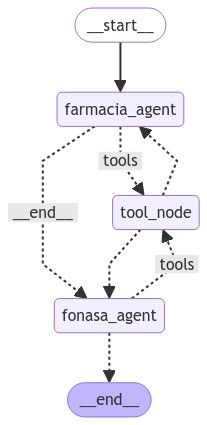

In [48]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [27]:
question = "¿Qué farmacia esta cerca del mall plaza egaña?"
app.invoke(
    {"messages": [SystemMessage(content=system_message), HumanMessage(content=question)]},
    config={"configurable": {"thread_id": 7}})

last message router 

[{'name': 'buscar_farmacia_mas_cercana', 'args': {'direccion': 'mall plaza egaña', 'GEOPY_API_KEY': 'your_geopy_api_key_here'}, 'id': 'call_xTqI1vvBG7Qe7E5Qo9Vg7wTr', 'type': 'tool_call'}]
La dirección es válida.
Latitud: -33.4519071, Longitud: -70.56871
Ciudad: La Reina, País: Chile
last message router 
```json
{
  "closest_pharmacy": {
    "pharmacy_name": "CRUZ VERDE",
    "address": "AV. LARRAIN 5862. LOCAL BF-117. MALL PLAZA EGAÑA",
    "city": "LA REINA",
    "opening_hours": "09:00:00",
    "closing_hours": "21:00:00",
    "distance": 0.1692579588851133
  },
  "closest_on_duty_pharmacy": {
    "pharmacy_name": "URGENCIA - AHUMADA",
    "address": "AVENIDA IRARRÁZAVAL 4221",
    "city": "LA REINA",
    "opening_hours": "00:00:00",
    "closing_hours": "23:59:00",
    "distance": 1.6275634861106962
  }
}
```
[]
last message router 

[{'name': 'farmacias_fonasa', 'args': {}, 'id': 'call_tydszdzTGibL9ologFZ97uY5', 'type': 'tool_call'}, {'name': 'farmacias_fonas

KeyError: 'farmacia_agent'

In [12]:
question = "¿Qué farmacia esta cerca del mall plaza egaña?"
#question = "¿que tomo para la fiebre?"
#question = input("Ingrese la pregunta: ")

# Define la consulta inicial y el mensaje del sistema
system_message = """
"""

app.invoke(
    {"messages": [SystemMessage(content=system_message), HumanMessage(content=question)]},
    config={"configurable": {"thread_id": 7}}
)

last message router 
```json
{
  "closest_pharmacy": {
    "pharmacy_name": "CRUZ VERDE",
    "address": "AV. LARRAIN 5862. LOCAL BF-117. MALL PLAZA EGAÑA",
    "city": "LA REINA",
    "opening_hours": "09:00:00",
    "closing_hours": "21:00:00",
    "distance": "0.169 km"
  },
  "closest_on_duty_pharmacy": {
    "pharmacy_name": "URGENCIA - AHUMADA",
    "address": "AVENIDA IRARRÁZAVAL 4221",
    "city": "LA REINA",
    "opening_hours": "00:00:00",
    "closing_hours": "23:59:00",
    "distance": "1.628 km"
  }
}
```
[]
last message router 
Aquí está la información actualizada de las farmacias cercanas al Mall Plaza Egaña, incluyendo si tienen convenio con FONASA:

1. **Farmacia más cercana:**
   - **Nombre de la farmacia:** CRUZ VERDE
   - **Dirección:** AV. LARRAIN 5862. LOCAL BF-117. MALL PLAZA EGAÑA
   - **Ciudad:** LA REINA
   - **Horario de apertura:** 09:00:00
   - **Horario de cierre:** 21:00:00
   - **Distancia:** 0.169 km
   - **Tiene convenio con FONASA:** No

2. **Farmacia

KeyError: 'farmacia_agent'

In [53]:
# Define the workflow
workflow = StateGraph(AgentState)
workflow.add_node("farmacia_agent", farmacia_agent)
workflow.add_node("fonasa_agent", fonasa_agent)
tools = tools_farmacia + tools_fonasa

workflow.add_node("tool_node", ToolNode(tools))

# Conditional edges
def should_continue(state: dict) -> Literal["tools", "__end__", "farmacia_agent"]:
    messages = state['messages']
    last_message = messages[-1]

    print(vars(last_message))
    
    print("Routing decision based on:", last_message.content.lower())

    content_lower = last_message.content.lower()

    if "farmacia" in content_lower or "buscar farmacia" in content_lower:
        print("Routing to farmacia_agent")
        return "farmacia_agent"
    if "final response" in content_lower:
        return "__end__"
    if "error" in content_lower:
        return "__end__"
    if last_message.tool_calls:
        return "tools"
    # Condición para finalizar después de `fonasa_agent`
    if last_message.role == "fonasa_agent":  # Verifica si `fonasa_agent` fue el último en responder
        return "__end__"  # Finaliza el flujo después de `fonasa_agent`

    return "__end__"

workflow.add_conditional_edges("farmacia_agent", should_continue, {"tools": "tool_node", "__end__": "fonasa_agent"})
workflow.add_conditional_edges("fonasa_agent", should_continue, {"tools": "tool_node", "__end__": END})

workflow.add_conditional_edges(
    "tool_node",
    lambda x: x["sender"],
    {
        "farmacia_agent": "farmacia_agent",
        "fonasa_agent": "fonasa_agent",
    },
)

workflow.set_entry_point("farmacia_agent")

# Print the nodes and edges for debugging
print("Registered nodes:", workflow.nodes)
print("Conditional edges:", workflow.edges)

# Compile the workflow without a checkpointer
app = workflow.compile()


Registered nodes: {'farmacia_agent': StateNodeSpec(runnable=farmacia_agent(recurse=True), metadata=None, input=<class 'agente_farmacia.utils.state.AgentState'>, retry_policy=None), 'fonasa_agent': StateNodeSpec(runnable=fonasa_agent(recurse=True), metadata=None, input=<class 'agente_farmacia.utils.state.AgentState'>, retry_policy=None), 'tool_node': StateNodeSpec(runnable=tools(recurse=True, tools_by_name={'buscar_farmacia_mas_cercana': StructuredTool(name='buscar_farmacia_mas_cercana', description='Encuentra la farmacia más cercana y la farmacia de turno más cercana a la dirección proporcionada.\n\nArgs:\n    direccion (str): La dirección para la cual se desea encontrar la farmacia más cercana.\n    GEOPY_API_KEY (str): Clave de API de Geopy para acceder a los servicios de geocodificación.\n\nReturns:\n    tuple: Una tupla que contiene dos diccionarios:\n        - El primer diccionario contiene la información de la farmacia más cercana con las claves:\n            "pharmacy_name" (str

In [52]:
message

NameError: name 'message' is not defined

In [54]:
question = "¿Qué farmacia esta cerca del mall plaza egaña?"
app.invoke(
    {"messages": [SystemMessage(content=system_message), HumanMessage(content=question)]},
    config={"configurable": {"thread_id": 7}})

{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_vbatVC49ISLEf1C5p5nMs85x', 'function': {'arguments': '{"direccion":"mall plaza egaña","GEOPY_API_KEY":"YOUR_GEOPY_API_KEY"}', 'name': 'buscar_farmacia_mas_cercana'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 35, 'prompt_tokens': 394, 'total_tokens': 429}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-91b473ea-9aa8-42b3-8023-a2bab3ab29d2-0', 'example': False, 'tool_calls': [{'name': 'buscar_farmacia_mas_cercana', 'args': {'direccion': 'mall plaza egaña', 'GEOPY_API_KEY': 'YOUR_GEOPY_API_KEY'}, 'id': 'call_vbatVC49ISLEf1C5p5nMs85x', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 394, 'output_tokens': 35, 'total_tokens': 429}}
Routing decision based on: 
La dirección es válida.
Latitud: -33.4519071, Longitud: -70.568

AttributeError: 'AIMessage' object has no attribute 'role'

In [11]:
# Definir herramientas para farmacia y FONASA
@tool
def buscar_farmacia_mas_cercana(direccion, GEOPY_API_KEY):
    """
    Encuentra la farmacia más cercana y la farmacia de turno más cercana a la dirección proporcionada.
    """
    referencia = coordenadas_direccion(direccion, GEOPY_API_KEY)
    if referencia is None:
        return None

    df_farmacias = get_pharmacy_data('https://midas.minsal.cl/farmacia_v2/WS/getLocales.php')
    local_mas_cercano = farmacia_mas_cercana(referencia, df_farmacias)

    df_farmacias_turno = get_pharmacy_data('https://midas.minsal.cl/farmacia_v2/WS/getLocalesTurnos.php')
    local_mas_cercano_turno = farmacia_mas_cercana(referencia, df_farmacias_turno)

    return {
        "pharmacy_name": local_mas_cercano["local_nombre"],
        "address": local_mas_cercano["local_direccion"],
        "city":  local_mas_cercano["comuna_nombre"],
        "opening_hours": local_mas_cercano["funcionamiento_hora_apertura"],
        "closing_hours": local_mas_cercano["funcionamiento_hora_cierre"],
        "distance": local_mas_cercano["distancia"]
    }, {
        "pharmacy_name": local_mas_cercano_turno["local_nombre"],
        "address": local_mas_cercano_turno["local_direccion"],
        "city":  local_mas_cercano_turno["comuna_nombre"],
        "opening_hours": local_mas_cercano_turno["funcionamiento_hora_apertura"],
        "closing_hours": local_mas_cercano_turno["funcionamiento_hora_cierre"],
        "distance": local_mas_cercano_turno["distancia"]
    }

# Definir el agente 'farmacia_agent'
def farmacia_agent(state: AgentState) -> AgentState:
    """
    Agente que maneja consultas sobre farmacias cercanas.
    """
    messages = state['messages']
    
    # Usar el prompt para crear la respuesta
    prompt = farmacia_prompt_template.format(messages=messages)
    
    # Enlazar la herramienta con el modelo de lenguaje
    tools_farmacia = [buscar_farmacia_mas_cercana]
    llm_farmacia = ChatOpenAI(model="gpt-4", temperature=0).bind_tools(tools_farmacia)
    
    response = llm_farmacia.invoke([HumanMessage(content=prompt)])

    # Actualizar el estado con el último agente
    state['messages'].append(response)
    state['last_agent'] = "farmacia_agent"  # Guardamos el último agente
    
    return state  # Retornamos el estado actualizado

@tool
def farmacias_fonasa():
    """
    Carga el dataset de farmacias que tienen convenio con FONASA por región.
    """
    dataset_fonasa = pd.read_csv('data/farmacias_fonasa_region.csv', encoding='iso-8859-1', sep=';')
    
    return dataset_fonasa

# Definir el agente 'fonasa_agent'
def fonasa_agent(state: AgentState) -> AgentState:
    """
    Agente que verifica si una farmacia tiene convenio con FONASA.
    """
    # Recuperar la respuesta del agente de farmacia
    farmacia_responses = state['messages'][-1].content  # Esto obtiene la última respuesta del farmacia_agent

    # Usar el prompt para crear la respuesta de FONASA
    prompt = fonasa_prompt_template.format(responses=farmacia_responses)
    
    tools_fonasa = [farmacias_fonasa]
    llm_fonasa = ChatOpenAI(model="gpt-4", temperature=0).bind_tools(tools_fonasa)
    
    response = llm_fonasa.invoke([HumanMessage(content=prompt)])

    # Actualizar el estado con el último agente
    state['messages'].append(response)
    state['last_agent'] = "fonasa_agent"  # Guardamos el último agente
    
    return state  # Retornamos el estado actualizado

# Función de continuidad ajustada
def should_continue(state: dict) -> Literal["tools", "__end__", "farmacia_agent"]:
    messages = state['messages']
    last_message = messages[-1]
    
    # Debug: Mostrar el último mensaje
    print("Último mensaje recibido: ", last_message.content)
    print("Llamadas a herramientas pendientes: ", last_message.tool_calls)

    # Normalizar el contenido del mensaje para facilitar las comparaciones
    content_lower = last_message.content.lower()

# Instructions:
    if "Error" in content_lower:
        return "__end__"
    if "FINAL RESPONSE" in content_lower:
        return "__end__"
    if "RE EVALUAR" in content_lower:
        return "farmacia_agent"
    if last_message.tool_calls:
        return "tools"
    return "__end__"

# Define the workflow
# Crear el flujo de estados (StateGraph)
workflow = StateGraph(AgentState)

# Agregar nodos para los agentes
workflow.add_node("farmacia_agent", farmacia_agent)
workflow.add_node("fonasa_agent", fonasa_agent)

# Definir las herramientas disponibles
tools = [buscar_farmacia_mas_cercana, farmacias_fonasa]
workflow.add_node("tool_node", ToolNode(tools))

# Definir las transiciones condicionales
workflow.add_conditional_edges("farmacia_agent", should_continue, {
    "tools": "tool_node",  # Si hay herramientas pendientes, ejecutarlas
    "__end__": "fonasa_agent"  # Luego de "farmacia_agent", pasar a "fonasa_agent"
})

workflow.add_conditional_edges("fonasa_agent", should_continue, {
    "tools": "tool_node",  # Si hay herramientas pendientes, ejecutarlas
    "__end__": END  # Luego de "fonasa_agent", detener el flujo
})

# Configurar las transiciones entre herramientas y agentes
workflow.add_conditional_edges(
    "tool_node",
    lambda state: state.get("last_agent", "farmacia_agent"),  # Volver al agente que invocó la herramienta
    {
        "farmacia_agent": "farmacia_agent",  # Volver a "farmacia_agent" si fue el último en ejecutarse
        "fonasa_agent": "fonasa_agent",  # Volver a "fonasa_agent" si fue el último en ejecutarse
    },
)

# Configurar el punto de entrada del flujo
workflow.set_entry_point("farmacia_agent")
compiled_workflow = workflow.compile()  # Guardamos el flujo compilado


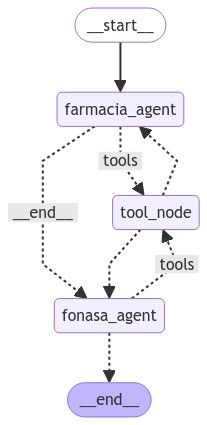

In [12]:
display(Image(compiled_workflow.get_graph(xray=True).draw_mermaid_png()))

In [13]:
def should_continue(state: dict) -> Literal["tools", "__end__", "farmacia_agent", "fonasa_agent"]:
    messages = state['messages']
    last_message = messages[-1]
    
    # Mostrar el último mensaje y las llamadas a herramientas
    print("Último mensaje recibido: ", last_message.content)
    print("Llamadas a herramientas pendientes: ", last_message.tool_calls)

    # Normalizar el contenido del mensaje
    content_lower = last_message.content.lower()

    # Si hay un error en el flujo, detener
    if "error" in content_lower:
        return "__end__"

    # Si el mensaje contiene "FINAL RESPONSE", detener el flujo
    if "final response" in content_lower:
        return "__end__"

    # Si se necesita reevaluar, volver al agente de farmacia
    if "re evaluar" in content_lower:
        return "farmacia_agent"

    # Verificar si ya se han ejecutado las herramientas
    if last_message.tool_calls:
        # Si las herramientas ya se ejecutaron, detener el flujo
        if state.get('tools_executed', False):
            print("Herramientas ya ejecutadas. Deteniendo flujo.")
            return "__end__"
        
        # Marcar que las herramientas fueron ejecutadas
        state['tools_executed'] = True
        return "tools"

    # Si venimos del agente de farmacia, transicionar a fonasa_agent
    last_agent = state.get("last_agent", None)
    if last_agent == "farmacia_agent":
        return "fonasa_agent"

    # Por defecto, detener el flujo si ninguna condición se cumple
    return "__end__"

# Crear el flujo de estados (StateGraph)
workflow = StateGraph(AgentState)

# Agregar nodos para los agentes
workflow.add_node("farmacia_agent", farmacia_agent)
workflow.add_node("fonasa_agent", fonasa_agent)

# Definir las herramientas disponibles
tools = [buscar_farmacia_mas_cercana, farmacias_fonasa]
workflow.add_node("tool_node", ToolNode(tools))

# Transiciones condicionales para farmacia_agent
workflow.add_conditional_edges("farmacia_agent", should_continue, {
    "tools": "tool_node",  # Si hay herramientas pendientes, ejecutarlas
    "fonasa_agent": "fonasa_agent"  # Luego de "farmacia_agent", pasar a "fonasa_agent"
})

# Transiciones condicionales para fonasa_agent
workflow.add_conditional_edges("fonasa_agent", should_continue, {
    "tools": "tool_node",  # Si hay herramientas pendientes, ejecutarlas
    "__end__": END  # Luego de "fonasa_agent", detener el flujo
})

# Configurar las transiciones entre herramientas y agentes
workflow.add_conditional_edges(
    "tool_node",
    lambda state: state.get("last_agent", "farmacia_agent"),  # Volver al agente que invocó la herramienta
    {
        "farmacia_agent": "farmacia_agent",  # Volver a "farmacia_agent" si fue el último en ejecutarse
        "fonasa_agent": "fonasa_agent",  # Volver a "fonasa_agent" si fue el último en ejecutarse
    },
)

# Configurar el punto de entrada del flujo
workflow.set_entry_point("farmacia_agent")

# Compilar el flujo de trabajo
compiled_workflow = workflow.compile()  # Guardar el flujo compilado



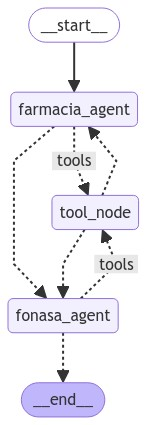

In [14]:
display(Image(compiled_workflow.get_graph(xray=True).draw_mermaid_png()))